# Description

The goal of this script is to design the notch spacing (c), length (h), depths ($g_o$, $g_i$), and angle/orientation ($\phi_o$, $\phi_i$) for a concentric push-pull robot.
Replicated using
*K. Oliver-Butler, J. A. Childs, A. Daniel and D. C. Rucker, "Concentric Push–Pull Robots: Planar Modeling and Design," in IEEE Transactions on Robotics, vol. 38, no. 2, pp. 1186-1200, April 2022, doi: 10.1109/TRO.2021.3104249.*


In [58]:
# Importing required libraries
import numpy as np
from numpy import pi,sin,cos,arccos
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.optimize import fsolve, minimize, LinearConstraint, least_squares

# Design Specifications

In [3]:
# Given design specifications

# Solving curvatures
L_curve = 15.0  # Length of curve in mm
n = 10          # Number of notch+rigid segments
beta = 0.5      # Proportion of the centerline curve that is considered to be rigid

# Solving notches
eps_max = .07     # Material strain limit
fs = 1.5          # Strain factor of safety
eps_fs = eps_max / fs # Strain limit

OD_o = 8.5    # Outer tube outer diameter in mm
ID_o = 7.5
OR_o = OD_o/2 # Outer tube outer radius
IR_o = ID_o/2

OD_i = 5.5    # Inner tube outer diameter
ID_i = 4.5
OR_i = OD_i/2 # Inner tube outer radius
IR_i = ID_i/2

E_o = 1  # Outer tube Young's modulus in GPa
E_i = 1.5  # Inner tube Young's modulus in GPa


[[ 0.   0.   0.   1. ]
 [ 3.6  0.   1.   1. ]
 [ 6.4  0.   2.   1. ]
 [ 8.4  0.   3.   1. ]
 [ 9.6  0.   4.   1. ]
 [10.   0.   5.   1. ]
 [ 9.6  0.   6.   1. ]
 [ 8.4  0.   7.   1. ]
 [ 6.4  0.   8.   1. ]
 [ 3.6  0.   9.   1. ]]


Create your desired curve and segment it into n-sections of even arc length. Assumes you have an analytical differentiable function for the desired curve

In [110]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve

def arc_length(df, a, b):
    """Calculate the arc length of a function f(x) from x=a to x=b."""
    result, _ = quad(lambda x: np.sqrt(1 + (df(x))**2), a, b)
    return result

def find_b(df, a, L, b_initial_guess):
    """Find b such that the arc length of f from a to b is L."""
    b_left, b_right = a, b_initial_guess
    while abs(arc_length(df, a, b_right) - L) > 1e-6:
        b_mid = (b_left + b_right) / 2
        if arc_length(df, a, b_mid) < L:
            b_left = b_mid
        else:
            b_right = b_mid
    return b_right

def find_x(df, x0, L):
    """Find x such that the arc length of f from x0 to x is L."""
    func = lambda x: arc_length(df, x0, x) - L
    x, = fsolve(func, x0 + L/df(x0))
    return x

def segment_curve(f, df, a, b, n):
    """Segment a curve y=f(x) from x=a to x=b into n segments of equal arc length."""
    L = arc_length(df, a, b)
    x_values = [a]
    for i in range(n):
        x = find_x(df, x_values[-1], L/n)
        x_values.append(x)
    z_values = [f(x) for x in x_values]
    return np.array([x_values, z_values]).T

# n+1 points of centerline tube segmented into equal arc lengths
shift = 4.0
peak = 4.0
f = lambda x: peak-(peak/shift**2)*(x-shift)**2 #10-0.4*(x-5)**2  # function
df = lambda x: -2*(peak/shift**2)*(x-shift)  # derivative
a = 0  # start point
b_initial_guess = 10  # initial guess for end point
b = find_b(df, a, L_curve, b_initial_guess)
points = segment_curve(f, df, a, b, n)

# Format as homogenous coordinate in x-z plane
p_des = np.zeros((points.shape[0], 4))
p_des[:, 0] = points[:, 1]
p_des[:, 1] = 0  # Y coord is zeros
p_des[:, 2] = points[:, 0]
p_des[:, 3] = 1  # Homogenous
print(p_des)

[[ 0.          0.          0.          1.        ]
 [ 1.31414739  0.          0.72228579  1.        ]
 [ 2.54050773  0.          1.58381104  1.        ]
 [ 3.56142594  0.          2.67550151  1.        ]
 [ 3.99822743  0.          4.08420377  1.        ]
 [ 3.46512783  0.          5.46269911  1.        ]
 [ 2.40960667  0.          6.52221595  1.        ]
 [ 1.16983741  0.          7.36461742  1.        ]
 [-0.15095097  0.          8.07477654  1.        ]
 [-1.51558585  0.          8.69705689  1.        ]
 [-2.90731271  0.          9.25635338  1.        ]]


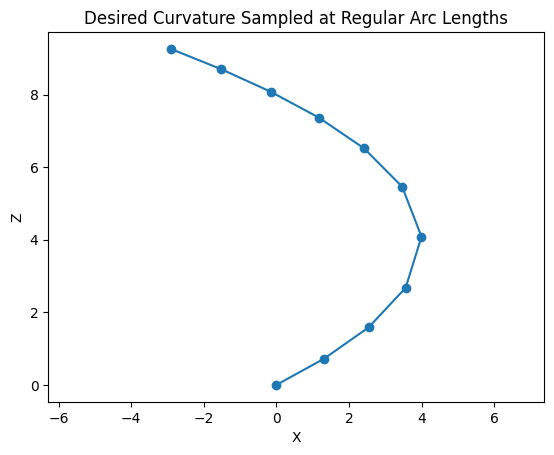

In [111]:
x_des = p_des[:, 0]
z_des = p_des[:, 2]

plt.plot(x_des, z_des, '-o', label='desired')

plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Desired Curvature Sampled at Regular Arc Lengths')

plt.show()

# Sample desired curve to get c, l, and $\kappa$


Calculate c and l

In [4]:
s = [(j-1)*L_curve/n for j in range(1,n+1)]   # discretize the curve into n segments
c = L_curve * beta / n        # length of rigid segment (Eq 14)
l = L_curve * (1-beta) / n    # length of notched segment (Eq 14)

Start at the base of the robot to find $\kappa_j$ curvature of each segment that minimizes error at each sampled point. The sampled point is the position at the end of the jth notched-rigid segment pair


In [5]:
# Create a rotation of angle in radians about axis
def get_rot_matrix(angle, axis):
    if axis == "x":
        R = np.array([[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]])
    elif axis == "y":
        R = np.array([[np.cos(angle), 0, np.sin(angle)], [0,1,0], [-np.sin(angle), 0, np.cos(angle)]])
    elif axis == "z":
        R = np.array([[np.cos(angle), -np.sin(angle), 0], [np.sin(angle), np.cos(angle), 0], [0,0,1]])
    else:
        print('axis must be "x", "y", or "z"')
        R = None
    return R

## fsolve version

In [185]:
R_y = get_rot_matrix(pi/2, "y")   # 90 deg rotation about y axis

def get_curve_endpoint(curvature, start_coord):
  """
  Assumes
    start_coord is a homogenous coordinate
    arc length is known
    """
  th = curvature * l  # curvature * arc length = theta

  # curvature bending transformation
  Tb_j = np.array([[math.cos(th), 0, math.sin(th), (1-np.cos(th)) / curvature],
                  [0, 1, 0, 0],
                  [-np.sin(th), 0, np.cos(th), np.sin(th) / curvature],
                  [0, 0, 0, 1]])

  # curvature bending translation
  Tr = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, c],
                  [0, 0, 0, 1]])

  # transform to get position at the end of jth segment, homogenous coordinate [x,y,z,1]
  return Tb_j @ Tr @ start_coord

def notch_segment_err(k_guess, p_jprev, p_des_j):
  # transform to get position at the end of jth segment, homogenous coordinate [x,y,z,1]
  p_j = get_curve_endpoint(k_guess, p_jprev)

  # arc length derivative of position at s_j = (dp_j/dl)
  x, y, z = p_j[:3]
  th = k_guess * l  # curvature * arc length = theta
  pprime_j = np.array([-k_guess*x*math.sin(th) + k_guess*(z+c)*math.cos(th) + math.sin(th),
                       0.0,
                       -k_guess*x*math.cos(th) - k_guess*(z+c)*math.sin(th) + math.cos(th)])  # ignore homogenous coord

  # component of error normal to the desired curve
  N_j = R_y @ pprime_j      # vector normal to the curve at s_j
  N_j = np.append(N_j, 1)
  e_j = N_j.T @ (p_j - p_des_j)

  return e_j

def solve_curvatures():
  # list of n k_j curvatures of segments
  curvatures = []

  # increment from the base
  p_jprev = np.array([0, 0, 0, 1])
  k_guess = 0.5
  k_j = 0.0

  for j in range(n):
      # desired position
      p_desj = np.reshape(p_des[j], p_des[j].size)

      # use fsolve to get curvatures that minimizes notch segment error
      k_j = fsolve(notch_segment_err, k_guess, args=(p_jprev, p_desj))
      curvatures.append(k_j.item()) # type(k_j.item()) is float vs fsolve default ndarray

      # use position and curvature as base for next iteration
      p_jprev = get_curve_endpoint(k_j, p_jprev)
      k_guess = k_j.item()

      print(f"iter {j} done")
  return curvatures

k_curves = solve_curvatures()
print(k_curves)

iter 0 done
iter 1 done
iter 2 done
iter 3 done
iter 4 done
iter 5 done
iter 6 done
iter 7 done
iter 8 done
iter 9 done
[2.3326605698044824e-17, -5.959714489793472e-13, -1.52276664928713e-08, -0.13932377754598457, -0.13244750383651446, -0.11309952038114607, -0.0876990970474954, -0.06338735108472429, -0.04196661476437172, -0.023739775123940602]


<ipython-input-185-05b422ac33cc>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Tb_j = np.array([[math.cos(th), 0, math.sin(th), (1-np.cos(th)) / curvature],
<ipython-input-185-05b422ac33cc>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pprime_j = np.array([-k_guess*x*math.sin(th) + k_guess*(z+c)*math.cos(th) + math.sin(th),
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, Run

## least_squares version
MATLAB fsolve() uses Levenberg-Marquardt Algorithm (LMA) which minimzes sum of squares. The equivalent is least_squares() for non-linear least squares problems that combines Gauss-Newton and Gradient Descent. Note it only supports bounds constraints. It's more suited for the problem compared to minimize() with SLSQP which is better for problems with inequality and equality constraints.

In [194]:
import math

R_y = get_rot_matrix(pi/2, "y")   # 90 deg rotation about y axis

def get_curve_endpoint(curvature, start_coord):
  """
  Assumes
    start_coord is a homogenous coordinate
    arc length is known
    """
  th = curvature * l  # curvature * arc length = theta

  # curvature bending transformation
  Tb_j = np.array([[math.cos(th), 0, math.sin(th), (1-math.cos(th)) / curvature],
                  [0, 1, 0, 0],
                  [-math.sin(th), 0, math.cos(th), math.sin(th) / curvature],
                  [0, 0, 0, 1]])

  # curvature bending translation
  Tr = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, c],
                  [0, 0, 0, 1]])

  # transform to get position at the end of jth segment, homogenous coordinate [x,y,z,1]
  return Tb_j @ Tr @ start_coord

def notch_segment_err(k_guess, p_jprev, p_des_j):
  # transform to get position at the end of jth segment, homogenous coordinate [x,y,z,1]
  # k_guess = k_guess.item()  # fsolve defaults using ndarray
  p_j = get_curve_endpoint(k_guess, p_jprev)

  # arc length derivative of position at s_j = (dp_j/dl)
  x, y, z = p_j[:3]
  th = k_guess * l  # curvature * arc length = theta
  pprime_j = np.array([-k_guess*x*math.sin(th) + k_guess*(z+c)*math.cos(th) + math.sin(th),
                       0.0,
                       -k_guess*x*math.cos(th) - k_guess*(z+c)*math.sin(th) + math.cos(th)])  # ignore homogenous coord

  # component of error normal to the desired curve
  N_j = R_y @ pprime_j      # vector normal to the curve at s_j
  N_j = np.append(N_j, 1)   # homogenous coord
  e_j = N_j.T @ (p_j - p_des_j)

  return e_j

def solve_curvatures():
  # list of n k_j curvatures of segments
  curvatures = []

  # increment from the base
  p_jprev = np.array([0, 0, 0, 1])
  k_guess = -1   # HIGHLY SENSITIVE TO INITIAL GUESS
  k_j = 0.0

  for j in range(n):
      # desired position
      p_desj = np.reshape(p_des[j], p_des[j].size)

      # use fsolve to get curvatures that minimizes notch segment error
      res = least_squares(notch_segment_err, k_guess, args=(p_jprev, p_desj), method='lm')
      if res.success:
        k_j = res.x[0]
        curvatures.append(k_j)
      else:
        print("not successful: ", res.message)

      # use position and curvature as base for next iteration
      p_jprev = get_curve_endpoint(k_j, p_jprev)
      k_guess = k_j

      print(f"iter {j} done")
  return curvatures

k_curves = solve_curvatures()
print(k_curves)

iter 0 done
iter 1 done
iter 2 done
iter 3 done
iter 4 done
iter 5 done
iter 6 done
iter 7 done
iter 8 done
iter 9 done
[2.332660569804482e-17, 2.332660569804482e-17, 2.332660569804482e-17, 2.332660569804482e-17, 2.332660569804482e-17, 2.332660569804482e-17, 2.332660569804482e-17, 2.332660569804482e-17, 2.332660569804482e-17, 2.332660569804482e-17]


<ipython-input-194-340d8365b32c>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Tb_j = np.array([[math.cos(th), 0, math.sin(th), (1-math.cos(th)) / curvature],
<ipython-input-194-340d8365b32c>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pprime_j = np.array([-k_guess*x*math.sin(th) + k_guess*(z+c)*math.cos(th) + math.sin(th),


Plot to Check Curvatures

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.31212157e-17 0.00000000e+00 1.50000000e+00 1.00000000e+00]
 [5.24848628e-17 0.00000000e+00 3.00000000e+00 1.00000000e+00]
 [1.18090941e-16 0.00000000e+00 4.50000000e+00 1.00000000e+00]
 [2.09939451e-16 0.00000000e+00 6.00000000e+00 1.00000000e+00]
 [3.28030393e-16 0.00000000e+00 7.50000000e+00 1.00000000e+00]
 [4.72363765e-16 0.00000000e+00 9.00000000e+00 1.00000000e+00]
 [6.42939570e-16 0.00000000e+00 1.05000000e+01 1.00000000e+00]
 [8.39757805e-16 0.00000000e+00 1.20000000e+01 1.00000000e+00]
 [1.06281847e-15 0.00000000e+00 1.35000000e+01 1.00000000e+00]
 [1.31212157e-15 0.00000000e+00 1.50000000e+01 1.00000000e+00]]


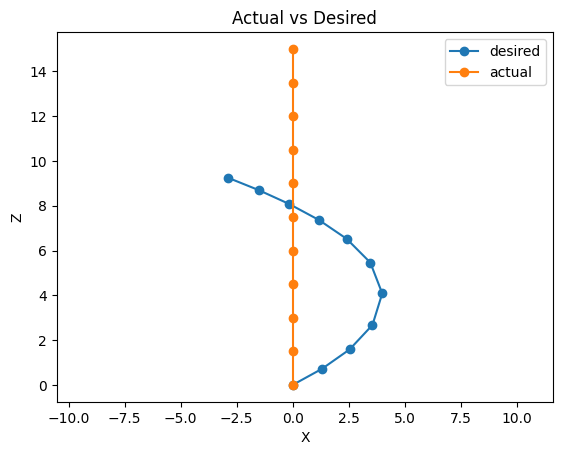

In [195]:
pts = np.zeros((n+1, 4))
pts[0,:] = np.array([0, 0, 0, 1])
for j in range(n):
  pts[j+1, :] = get_curve_endpoint(k_curves[j], pts[j,:])
print(pts)

x_act = pts[:, 0]
z_act = pts[:, 2]
x_des = p_des[:, 0]
z_des = p_des[:, 2]

plt.plot(x_des, z_des, '-o', label='desired')
plt.plot(x_act, z_act, '-o', label='actual')

plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Actual vs Desired')
plt.legend()

plt.show()

# Optimize Notch Depths to Fit Curve and Maximize Stiffness

function get_strain

In [20]:
def strain_mag_a(k, OD, gammabar):
  """ Calculate strain magnitude in the inner wall (a) of a tube notch
  Input: segment curvature (k), outer diameter (OD), neutral axis (gamma)
  Output: float
  """
  return np.abs(k)*(OD/2 - gammabar)

def strain_mag_b(k, OD, gammabar, g):
  """ Calculate strain magnitude in the outer edge (b) of a tube notch
  Input: segment curvature (k), outer diameter (OD), neutral axis (gamma), cut depth (g)
  Output: float
  """
  return np.abs(k)*(OD/2 + gammabar - g)

In [22]:
import numpy as np
from math import sin, acos, pi

def depth_phi(g, r_i, r_o):
  if g - r_o <= r_i:
      arg_o = (g - r_o) / r_o
      arg_i = (g - r_o) / r_i   # Note: geometrically correct, paper has wrong equation

      if not (-1 <= arg_o <= 1 and -1 <= arg_i <= 1):
          print("illegal phi. g, r_i, r_o: ", g, r_i, r_o)
          return None, None

      phi_o = 2 * np.arccos(arg_o)
      phi_i = 2 * np.arccos(arg_i)
  return phi_o, phi_i


# Given: depth g, inner radius r_i, outer radius r_o of a given tube
# Find: neutral bending plane, gamma
# Modified from paper to account for scenarios when backcalculating would result in nan
def calculate_gammabar(g, r_i, r_o):
    if g - r_o <= r_i:
      phi_o, phi_i = depth_phi(g, r_i, r_o)

      A_o = (r_o**2 * (phi_o - np.sin(phi_o))) / 2
      A_i = (r_i**2 * (phi_i - np.sin(phi_i))) / 2
      A = A_o - A_i

      # if np.isclose(A, 0, atol=1e-8):
      #     return None, A

      gamma_o = (4 * r_o * np.sin(0.5 * phi_o)**3) / (3 * (phi_o - np.sin(phi_o)))
      gamma_i = (4 * r_i * np.sin(0.5 * phi_i)**3) / (3 * (phi_i - np.sin(phi_i)))

      gamma = (gamma_o * A_o - gamma_i * A_i) / A
      gammabar = abs(gamma)

    else:
      # TODO: set constraint about the minimum thickness
      # condition: when cutdepth goes too far and A_i becomes zero
      arg_o = (g - r_o) / r_o
      if not (-1 <= arg_o <= 1):
          print("illegal phi")
          return None, None

      phi_o = 2 * np.arccos(arg_o)
      A = (r_o**2 * (phi_o - np.sin(phi_o))) / 2

      gamma_o = (4 * r_o * np.sin(0.5 * phi_o)**3) / (3 * (phi_o - np.sin(phi_o)))
      gammabar = abs(gamma_o)

    return gammabar, A

def gammabar_loss_function(g, target_gammabar, IR, OR):
    calculated_gammabar, A = calculate_gammabar(g, IR, OR)
    if calculated_gammabar is None:
        return float('inf')
    return (calculated_gammabar - target_gammabar) ** 2

def numerical_gradient(f, x, h=1e-5):
    return (f(x + h) - f(x - h)) / (2 * h)

def gammabar_gradient_descent(g_initial, target_gammabar, IR, OR, learning_rate, num_iterations, grad_threshold=1e-6, loss_threshold=0.003):
    g = g_initial
    last_g = 0
    min_thickness = 0.25 # mm
    for i in range(num_iterations):
        grad = numerical_gradient(lambda g: gammabar_loss_function(g, target_gammabar, IR, OR), g)
        g -= learning_rate * grad

        if g - OR < 0: # depth is too shallow
          g = OR
        elif OR*2 - g < min_thickness:  # notch depth goes beyond minimum thickness
          g = last_g
          break
        current_loss = gammabar_loss_function(g, target_gammabar, IR, OR)

        if i % 20 == 0:
            print(f"Iteration {i}, g: {g}, Gradient: {grad}, Loss: {current_loss}")

        if abs(grad) < grad_threshold or current_loss < loss_threshold:
            print("Threshold reached, stopping iterations.")
            break

        last_g = g
    return g

# def gammabar_gradient_descent(g_initial, target_gammabar, IR, OR, learning_rate, num_iterations, loss_threshold = 0.0001):
#     g = g_initial
#     for i in range(num_iterations):
#         grad = numerical_gradient(lambda g: gammabar_loss_function(g, target_gammabar, IR, OR), g)
#         g -= learning_rate * grad


#         print(f"Iteration {i}, g: {g}, Gradient: {grad}, Loss: {gammabar_loss_function(g, target_gammabar, IR, OR)}")

#     return g

# Example usage
g_initial = 4.25  # Initial guess for g
target_gammabar = 4.22  # The target gammabar value
IR = 7.5/2  # Inner radius
OR = 4.25  # Outer radius
learning_rate = 0.01  # Learning rate for the gradient descent
num_iterations = 1000  # Number of iterations for the gradient descent

g_optimal = gammabar_gradient_descent(g_initial, target_gammabar, IR, OR, learning_rate, num_iterations)
print("Optimal g:", g_optimal)


Iteration 0, g: 4.263555801110066, Gradient: -1.3555801110065602, Loss: 2.771248795611603
Iteration 20, g: 4.523029265532854, Gradient: -1.2472305773059134, Loss: 2.435121605086758
Iteration 40, g: 4.762380312162719, Gradient: -1.153076143189935, Loss: 2.1490910879736584
Iteration 60, g: 4.984126567413229, Gradient: -1.070212606757437, Loss: 1.9035777849161275
Iteration 80, g: 5.190294996000568, Gradient: -0.996539740039104, Loss: 1.691338967724682
Iteration 100, g: 5.382551895583589, Gradient: -0.9304899868389781, Loss: 1.5067693550217993
Iteration 120, g: 5.562290724414078, Gradient: -0.8708625305886563, Loss: 1.3454471547667222
Iteration 140, g: 5.730693562815549, Gradient: -0.8167172438011682, Loss: 1.2038281373042818
Iteration 160, g: 5.888775408310922, Gradient: -0.7673043706857284, Loss: 1.0790329343241791
Iteration 180, g: 6.037416908290538, Gradient: -0.7220164290389074, Loss: 0.968695194952385
Iteration 200, g: 6.177389077579604, Gradient: -0.6803544373379377, Loss: 0.8708507

In [44]:
# I : second moment of area
# IR, OR: the inner and outer radius of the circle
# phi : the central angle of the segment in radians.
# y : offset distance
# A: cross sectional area
# reference: https://structx.com/Shape_Formulas_003.html

def calculate_I(g, r_i, r_o):
  if g - r_o <= r_i:
    phi_o, phi_i = depth_phi(g, r_i, r_o)

    A_o = (r_o**2 * (phi_o - np.sin(phi_o))) / 2
    A_i = (r_i**2 * (phi_i - np.sin(phi_i))) / 2
    A = A_o - A_i

    # if np.isclose(A, 0, atol=1e-8):
    #     return None, A

    gamma_o = (4 * r_o * np.sin(0.5 * phi_o)**3) / (3 * (phi_o - np.sin(phi_o)))
    gamma_i = (4 * r_i * np.sin(0.5 * phi_i)**3) / (3 * (phi_i - np.sin(phi_i)))

    gamma = (gamma_o * A_o - gamma_i * A_i) / A
    gammabar = abs(gamma)

    # calulate I_c (passing through the center)
    I_c = OR**4/8 * (phi_o - sin(phi_o) + 2 * sin(phi_o) * sin(phi_o/2)**2)
    I_c -= IR**4/8 * (phi_i - sin(phi_i) + 2 * sin(phi_i) * sin(phi_i/2)**2)    # --- added from Zhongchun's script

  else:
    # condition: when cutdepth goes too far and A_i becomes zero
    arg_o = (g - r_o) / r_o
    if not (-1 <= arg_o <= 1):
        print("illegal phi, thickness left: ", 2*r_o - g)
        return None, None

    phi_o = 2 * np.arccos(arg_o)
    A = (r_o**2 * (phi_o - np.sin(phi_o))) / 2

    gamma_o = (4 * r_o * np.sin(0.5 * phi_o)**3) / (3 * (phi_o - np.sin(phi_o)))
    gammabar = abs(gamma_o)

    # calulate I_c (passing through the center)
    I_c = OR**4/8 * (phi_o - sin(phi_o) + 2 * sin(phi_o) * sin(phi_o/2)**2)

  # calculate I_offset (about the offset axis)
  I_offset = I_c + A * gammabar**2

  return I_offset

def I_loss_function(g, target_I, IR, OR):
  calculated_I = calculate_I(g, IR, OR)
  if calculated_I is None:
    print('calc I is None')
    return float('inf')
  return 0.25 * (calculated_I - target_I) ** 2

def numerical_gradient(f, x, h=1e-5):
  return (f(x + h) - f(x - h)) / (2 * h)

def I_gradient_descent(g_initial, target_I, IR, OR, learning_rate, num_iterations, grad_threshold=1e-6, loss_threshold=0.003):
  g = g_initial
  last_g = 0
  min_thickness = 0.25 # mm
  for i in range(num_iterations):
    grad = numerical_gradient(lambda g: I_loss_function(g, target_I, IR, OR), g)
    g -= learning_rate * grad

    if g < OR: # depth is too shallow
      g = OR + 0.01
      print("depth too shallow")
    elif OR*2 - g < min_thickness:  # notch depth goes beyond minimum thickness
      g = OR*2 - min_thickness
      print("I grad descent notch too deep")
      break

    current_loss = I_loss_function(g, target_I, IR, OR)

    if i % 20 == 0:
      print(f"Iteration {i}, g: {g}, Gradient: {grad}, Loss: {current_loss}")

    if abs(grad) < grad_threshold or current_loss < loss_threshold:
      print("Threshold reached, stopping iterations.")
      break

    last_g = g
  return g

In [45]:
# let i~inner tube, o~outer tube, 2~inner radius of a tube, 1~outer radius of a tube
# assume n-curvatures are known

# --- Initialize guess of max strained pair --- #
# init assume highest curved outer tube is most strained
m = np.argmax(k_curves)
print("m: ", m)
k_m = k_curves[m]

# back calculate cut depth of outer tube at m-th segment g_o,m
target_gammabar_om = (OD_o/2) - (eps_fs / np.abs(k_m))
g_om_guess = OR_o + (OR_o - IR_o) / 2
g_om = gammabar_gradient_descent(g_om_guess, target_gammabar_om, IR_o, OR_o, learning_rate=0.01, num_iterations=1000)
print("g_om: ", g_om)

# second moment of area outer tube
I_om = calculate_I(g_om, IR_o, OR_o)

# assuming EI(inner) = EI(outer), backcalculate depth of inner tube at m-th segment g_i,m
I_im = E_o * I_om / E_i
g_im_guess = OR_i + (OR_i - IR_i) / 2
# g_im = I_gradient_descent(g_im_guess, I_im, IR_i, OR_i, learning_rate=0.01, num_iterations=1000, loss_threshold=0.006)
min_thickness = 0.25
res = minimize(I_loss_function, g_im_guess, args=(I_im, IR_o, OR_o), bounds=[(OR_i, 2*OR-min_thickness)])
if res.success:
  g_im = res.x[0]
  print("g_im loss: ", I_loss_function(g_im, I_im, IR_i, OR_i))
  print("num iter: ", res.nit)
else:
  print("not successful: ", res.message)
print("g_im: ", g_im)

# --- Calculate remaining depths using alpha compliance constraint --- #
# n-length arrays of final quantities
g_inner_depths = np.zeros((n))
eps = np.zeros((n, 4))

# populate guesses of outer cut depths
g_outer_depths = [g_om * np.abs(k_curves[j]/k_m) for j in range(n)]

for j in range(n):
  # outer tube depth
  g_o = g_outer_depths[j]

  # neutral axis for outer tube
  gammabar_o, A_o = calculate_gammabar(g_o, IR_o, OR_o)

  # second moment of area outer tube
  I_o = calculate_I(g_o, IR_o, OR_o)

  # assuming EI(inner) = EI(outer)
  I_i = E_o * I_o / E_i

  # alpha constraint for m pair. d can use gammabar because signs of alpha and kappa would cancel in constraint
  gammabar_om, _ = calculate_gammabar(g_om, IR_o, OR_o)    # -- TO DO: is this redundant ??
  gammabar_im, _ = calculate_gammabar(g_im, IR_i, OR_i)
  alpha_m = (gammabar_im - gammabar_om) / (E_o * I_om + E_i * I_im)   # -- TO DO: does I_im have to be recalc using g_im?

  # use alpha constraint backcalculate g_inner
  alpha_j = alpha_m * k_curves[j] / k_m
  target_gammabar_i = alpha_j * (E_o * I_o + E_i * I_i) + gammabar_o
  g_i_guess = g_o
  g_i = gammabar_gradient_descent(g_i_guess, target_gammabar_i, IR_i, IR_o, learning_rate=0.01, num_iterations=1000)
  g_inner_depths[j] = g_i

  # calculate strain in notch pair
  gammabar_i, _ = calculate_gammabar(g_i, IR_i, OR_i)    # -- TO DO: is this redundant ??
  eps[j] = np.array([strain_mag_a(k_curves[j], OD_o, gammabar_o),
         strain_mag_b(k_curves[j], OD_o, gammabar_o, g_o),
         strain_mag_a(k_curves[j], OD_i, gammabar_i),
         strain_mag_b(k_curves[j], OD_i, gammabar_i, g_i)])

# find highest strained notch pair
m_prime = np.argmax(np.max(eps, axis=1))
print("m': ", m_prime)

# get final notch depths
best = np.argmax(np.sum(g_outer_depths, axis=1))
g_outer = g_outer_depths[best]
g_inner = g_inner_depths[best]

m:  6
Iteration 0, g: 4.512508753677087, Gradient: -1.250875367708737, Loss: 2.4458073023138978
Iteration 20, g: 4.752536684941962, Gradient: -1.156242531519247, Loss: 2.1581573086442183
Iteration 40, g: 4.974874583219931, Gradient: -1.0729951614996125, Loss: 1.9113325951267395
Iteration 60, g: 5.181565517021365, Gradient: -0.999007897184434, Loss: 1.6980169773962508
Iteration 80, g: 5.374287782411609, Gradient: -0.932696193911564, Loss: 1.5125530305779487
Iteration 100, g: 5.554444011779343, Gradient: -0.8728473474550745, Loss: 1.3504809021481798
Iteration 120, g: 5.723223453351574, Gradient: -0.8185126657012097, Loss: 1.2082279279602453
Iteration 140, g: 5.881646808226611, Gradient: -0.7689360603468919, Loss: 1.0828930748122902
Iteration 160, g: 6.030599333642967, Gradient: -0.7235052743581604, Loss: 0.972093204660048
Iteration 180, g: 6.17085582015974, Gradient: -0.6817176467721618, Loss: 0.8738509015119489
Iteration 200, g: 6.303099799621672, Gradient: -0.6431555343411333, Loss: 0.

TypeError: ignored

In [ ]:
x = np.arange(6).reshape((3, 2))
print(x)
print(np.shape(x))
print(np.shape(x[1,:]))

row = np.reshape(x[1], (-1,1))
print(row)
print(row.shape)

print("hello")

Workshopped

In [ ]:
import numpy as np
from math import sin, acos, pi

# Given: depth g, inner radius r_i, outer radius r_o of a given tube
# Find: neutral bending plane, gamma
# Modified from paper to account for scenarios when backcalculating would result in nan
def calculate_gammabar(g, r_i, r_o):
    if g - r_o <= r_i:
      arg_o = (g - r_o) / r_o
      arg_i = (g - r_o) / r_i   # Note: geometrically correct, paper has wrong equation

      if not (-1 <= arg_o <= 1 and -1 <= arg_i <= 1):
          print("illegal phi")
          return None, None

      phi_o = 2 * np.arccos(arg_o)
      phi_i = 2 * np.arccos(arg_i)

      A_o = (r_o**2 * (phi_o - np.sin(phi_o))) / 2
      A_i = (r_i**2 * (phi_i - np.sin(phi_i))) / 2
      A = A_o - A_i

      # if np.isclose(A, 0, atol=1e-8):
      #     return None, A

      gamma_o = (4 * r_o * np.sin(0.5 * phi_o)**3) / (3 * (phi_o - np.sin(phi_o)))
      gamma_i = (4 * r_i * np.sin(0.5 * phi_i)**3) / (3 * (phi_i - np.sin(phi_i)))

      gamma = (gamma_o * A_o - gamma_i * A_i) / A
      gammabar = abs(gamma)

    else:
      # TODO: set constraint about the minimum thickness
      # condition: when cutdepth goes too far and A_i becomes zero
      arg_o = (g - r_o) / r_o
      if not (-1 <= arg_o <= 1):
          print("illegal phi")
          return None, None

      phi_o = 2 * np.arccos(arg_o)
      A = (r_o**2 * (phi_o - np.sin(phi_o))) / 2

      gamma_o = (4 * r_o * np.sin(0.5 * phi_o)**3) / (3 * (phi_o - np.sin(phi_o)))
      gammabar = abs(gamma_o)

    return gammabar

def loss_function(g, target_gammabar, IR, OR):
    calculated_gammabar = calculate_gammabar(g, IR, OR)
    if calculated_gammabar is None:
        return float('inf')
    return (calculated_gammabar - target_gammabar) ** 2

def numerical_gradient(f, x, h=1e-5):
    return (f(x + h) - f(x - h)) / (2 * h)

def gradient_descent(g_initial, target_gammabar, IR, OR, learning_rate, num_iterations, grad_threshold=1e-6, loss_threshold=0.003):
    g = g_initial
    for i in range(num_iterations):
        grad = numerical_gradient(lambda g: loss_function(g, target_gammabar, IR, OR), g)
        g -= learning_rate * grad
        current_loss = loss_function(g, target_gammabar, IR, OR)

        if i % 20 == 0:
            print(f"Iteration {i}, g: {g}, Gradient: {grad}, Loss: {current_loss}")

        if abs(grad) < grad_threshold or current_loss < loss_threshold:
            print("Threshold reached, stopping iterations.")
            break
    return g

# def gradient_descent(g_initial, target_gammabar, IR, OR, learning_rate, num_iterations, loss_threshold = 0.0001):
#     g = g_initial
#     for i in range(num_iterations):
#         grad = numerical_gradient(lambda g: loss_function(g, target_gammabar, IR, OR), g)
#         g -= learning_rate * grad


#         print(f"Iteration {i}, g: {g}, Gradient: {grad}, Loss: {loss_function(g, target_gammabar, IR, OR)}")

#     return g

# Example usage
g_initial = 4.25  # Initial guess for g
target_gammabar = 4.22  # The target gammabar value
IR = 7.5/2  # Inner radius
OR = 4.25  # Outer radius
learning_rate = 0.01  # Learning rate for the gradient descent
num_iterations = 1000  # Number of iterations for the gradient descent

g_optimal = gradient_descent(g_initial, target_gammabar, IR, OR, learning_rate, num_iterations)
print("Optimal g:", g_optimal)


Iteration 0, g: 4.263555801110066, Gradient: -1.3555801110065602, Loss: 2.771248795611603
Iteration 20, g: 4.523029265532854, Gradient: -1.2472305773059134, Loss: 2.435121605086758
Iteration 40, g: 4.762380312162719, Gradient: -1.153076143189935, Loss: 2.1490910879736584
Iteration 60, g: 4.984126567413229, Gradient: -1.070212606757437, Loss: 1.9035777849161275
Iteration 80, g: 5.190294996000568, Gradient: -0.996539740039104, Loss: 1.691338967724682
Iteration 100, g: 5.382551895583589, Gradient: -0.9304899868389781, Loss: 1.5067693550217993
Iteration 120, g: 5.562290724414078, Gradient: -0.8708625305886563, Loss: 1.3454471547667222
Iteration 140, g: 5.730693562815549, Gradient: -0.8167172438011682, Loss: 1.2038281373042818
Iteration 160, g: 5.888775408310922, Gradient: -0.7673043706857284, Loss: 1.0790329343241791
Iteration 180, g: 6.037416908290538, Gradient: -0.7220164290389074, Loss: 0.968695194952385
Iteration 200, g: 6.177389077579604, Gradient: -0.6803544373379377, Loss: 0.8708507